# Idea
Do some training

In [1]:
SEED = 133
TIME_WINDOW = "30s"
DATA_FILE = '../../data/all_df_30s_Heqing_device2.csv'

In [2]:
from pathlib import Path

import numpy as np
import pandas as pd
import pickle

assert Path(DATA_FILE).exists()

In [3]:
import sys
repo_base_path = Path("./../../../").resolve()
assert str(repo_base_path).endswith("csg_is"), f"{repo_base_path} is not a valid path to the CSG_IS repository" 

sys.path.append(str(repo_base_path))
sys.path.append("..")

# from py_dataset import get_all_files_df
# from py_dataset import read_in_files
from py_dataset import feature_plotting
# from py_dataset import feature_selection
# from py_dataset import net_feature_engineering
# from py_dataset import entropy_feature_engineering
# from py_dataset.classes import DataSource
from py_dataset import sys_func

from py_dataset.classes import DataSource



In [4]:
LOG_PATH = (repo_base_path / "training" / "official_logs")
LOG_NAME = f"multi-layer_300_{TIME_WINDOW}"
LOG_NAME_EXPERIMENT_2 = f"single-layer_30_from_weights_{TIME_WINDOW}"
LOG_NAME_EXPERIMENT_3 = f"multi-layer_30_from_weights_{TIME_WINDOW}"

assert LOG_PATH.exists()
assert not (LOG_PATH / LOG_NAME).exists(), "are you sure to run this again?"
assert not (LOG_PATH / LOG_NAME_EXPERIMENT_2).exists(), "are you sure to run this again?"
assert not (LOG_PATH / LOG_NAME_EXPERIMENT_3).exists(), "are you sure to run this again?"

AssertionError: are you sure to run this again?

In [5]:
df = pd.read_csv(DATA_FILE)
df.set_index("timestamp", inplace=True)

In [6]:
assert df["label"].unique().shape == (10,)

### Preprocessings
- remove Null values
- drop timestamp
- labelEncode
- normalize

In [7]:
print(df.shape)
old_df = df.copy()
df.dropna(axis=0, how='any', inplace=True)

print(df.shape)

(28869, 306)
(21765, 306)


In [8]:
df.reset_index(inplace=True, drop=True)

In [9]:
label_encoder = sys_func.create_label_encoder_for_labels()
df['label'] = label_encoder.transform(df['label'])

In [10]:
df = feature_plotting.test_transform_all_to_numeric_columns(df)

In [11]:
cols_to_exclude_from_scaling = ["label"]
vectors = feature_plotting.minmax_scale_features(df,remove_outliers_iqr_all_columns=False,
                                                        cols_to_exclude_from_scaling=cols_to_exclude_from_scaling)
# print(vectors.shape)
# print(" with dropped null: ", vectors.dropna(axis=0, how='any', inplace=False).shape)

In [12]:
df["label"].unique(), vectors["label"].unique()

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), array([0, 1, 2, 3, 4, 5, 6, 7, 8]))

Label 0: 2285 samples
Label 1: 2420 samples
Label 2: 2820 samples
Label 3: 2355 samples
Label 4: 2365 samples
Label 5: 2390 samples
Label 6: 2370 samples
Label 7: 2360 samples
Label 8: 2400 samples


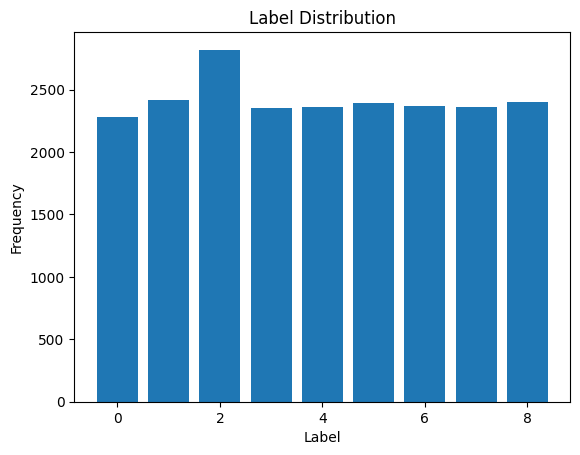

In [13]:
feature_plotting.check_label_distribution(vectors)

### Setup

In [14]:
from torch.utils.data import Dataset, DataLoader
import torch

class CustomeDataset(Dataset):
    def __init__(self, some_df:pd.DataFrame):
        
        self.x = torch.tensor(some_df.drop(columns=["label"], inplace=False).values, dtype=torch.float32)
        self.labels = torch.tensor(some_df["label"].values, dtype=torch.uint8)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        # if torch.is_tensor(idx):
        #     idx = idx.tolist()
        # print(self.x[idx], self.labels[idx])
        return self.x[idx], self.labels[idx]

In [15]:
sys.path.append(str(repo_base_path  / "training"))

In [17]:
from mlp import MalwaresModelMLP
from torch.utils.data import DataLoader
import lightning
from sklearn.model_selection import train_test_split
from pytorch_lightning import loggers as pl_loggers
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks.model_checkpoint import ModelCheckpoint

tensorboard = pl_loggers.TensorBoardLogger(save_dir=LOG_PATH, name=LOG_NAME)

# split into train and val
train, val = train_test_split(vectors, test_size=0.2, random_state=SEED)

train_dataset = CustomeDataset(train)
train_dataloader = DataLoader(train_dataset, batch_size=500, shuffle=True, num_workers=7)

val_dataset = CustomeDataset(val)
val_dataloader = DataLoader(val_dataset, batch_size=500, shuffle=False, num_workers=7)

# trainer = lightning.Trainer(fast_dev_run=100)
monitor = "Validation/Accuracy"
early_stop_callback = EarlyStopping(monitor=monitor, patience=5, verbose=True, mode="max")
checkpoint_callback = ModelCheckpoint(save_top_k=1, monitor=monitor, mode="max")

trainer = lightning.Trainer(max_epochs=150, callbacks=[early_stop_callback, checkpoint_callback], enable_checkpointing=True, logger=tensorboard) #logger=None, 


model = MalwaresModelMLP(input_size = vectors.shape[1]-1, output_size = len(label_encoder.classes_), seed=SEED)

torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [18]:
trainer.fit(model=model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

Missing logger folder: /home/<User>/repos/csg_is/training/official_logs/multi-layer_300_30s
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                      | Params
------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0     
1 | val_metrics   | MetricCollection          | 0     
2 | test_metrics  | MetricCollection          | 0     
3 | cm            | MulticlassConfusionMatrix | 0     
4 | criterion     | CrossEntropyLoss          | 0     
5 | l1            | Linear                    | 9.2 K 
6 | l2            | Linear                    | 930   
7 | l3            | Linear                    | 279   
------------------------------------------------------------
10.4 K    Trainable params
0         Non-trainable params
10.4 K    Total params
0.042     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Epoch end: Validation, epoch number: 0
ValidationEpoch/CM
 tensor([[  0,   0,   0,   0,   0,  98,   0,   0,   0],
        [  0,   0,   0,   0,   0, 123,   0,   0,   0],
        [  0,   0,   0,   0,   0, 133,   0,   0,   0],
        [  0,   0,   0,   0,   0,  95,   0,   0,   0],
        [  0,   0,   0,   0,   0, 113,   0,   0,   0],
        [  0,   0,   0,   0,   0, 118,   0,   0,   0],
        [  0,   0,   0,   0,   0, 101,   0,   0,   0],
        [  0,   0,   0,   0,   0, 109,   0,   0,   0],
        [  0,   0,   0,   0,   0, 110,   0,   0,   0]])


/home/<User>/repos/csg_is/.venv/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:280: The number of training batches (35) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch end: Validation, epoch number: 1
ValidationEpoch/CM
 tensor([[ 337,    1,  274,  898,  377,  276,  175,   45,    0],
        [   0, 2333,    0,    0,    0,  209,    0,    1,    0],
        [  78,   13, 1417,  163,  121,  516,  494,  151,    0],
        [ 411,    0,  265,  913,  319,  307,  193,   42,    0],
        [ 141,    0,  193,  593,  989,  309,  213,   40,    0],
        [   0,   38,  185,    0,    0, 2015,    5,  265,    0],
        [ 122,    0,  871,  243,  180,  366,  577,  112,    0],
        [   0,    0,    0,    0,    0,  172,    0, 2297,    0],
        [   0,    0,    0,    0,    0,  181,    0,    4, 2325]])
Epoch end: Train, epoch number: 0
TrainEpoch/CM
 tensor([[ 337,    1,  274,  898,  377,  276,  175,   45,    0],
        [   0, 2333,    0,    0,    0,  209,    0,    1,    0],
        [  78,   13, 1417,  163,  121,  516,  494,  151,    0],
        [ 411,    0,  265,  913,  319,  307,  193,   42,    0],
        [ 141,    0,  193,  593,  989,  309,  213,   40,   

Metric Validation/Accuracy improved. New best score: 0.714


Validation: 0it [00:00, ?it/s]

Epoch end: Validation, epoch number: 2
ValidationEpoch/CM
 tensor([[1175,    1,  283, 2122,  458,  276,  308,   45,    0],
        [   0, 4753,    0,    0,    0,  209,    0,    1,    0],
        [ 116,   19, 3609,  213,  131,  560,  974,  151,    0],
        [1220,    0,  313, 2155,  379,  307,  389,   42,    0],
        [ 221,    0,  205,  760, 3009,  319,  289,   40,    0],
        [   0,   38,  201,    0,    0, 4389,    5,  265,    0],
        [ 301,    0, 1911,  551,  224,  381, 1361,  112,    0],
        [   0,    0,    0,    0,    0,  172,    0, 4657,    0],
        [   0,    0,    0,    0,    0,  181,    0,    4, 4725]])


Metric Validation/Accuracy improved by 0.061 >= min_delta = 0.0. New best score: 0.776


Epoch end: Train, epoch number: 1
TrainEpoch/CM
 tensor([[1175,    1,  283, 2122,  458,  276,  308,   45,    0],
        [   0, 4753,    0,    0,    0,  209,    0,    1,    0],
        [ 116,   19, 3609,  213,  131,  560,  974,  151,    0],
        [1220,    0,  313, 2155,  379,  307,  389,   42,    0],
        [ 221,    0,  205,  760, 3009,  319,  289,   40,    0],
        [   0,   38,  201,    0,    0, 4389,    5,  265,    0],
        [ 301,    0, 1911,  551,  224,  381, 1361,  112,    0],
        [   0,    0,    0,    0,    0,  172,    0, 4657,    0],
        [   0,    0,    0,    0,    0,  181,    0,    4, 4725]])


Validation: 0it [00:00, ?it/s]

Epoch end: Validation, epoch number: 3
ValidationEpoch/CM
 tensor([[2653,    1,  283, 2852,  477,  276,  366,   45,    0],
        [   0, 7173,    0,    0,    0,  209,    0,    1,    0],
        [ 123,   19, 5771,  237,  133,  586, 1573,  151,    0],
        [2525,    0,  329, 3011,  387,  307,  559,   42,    0],
        [ 253,    0,  205,  767, 5325,  320,  298,   40,    0],
        [   0,   38,  202,    0,    0, 6778,    5,  265,    0],
        [ 529,    0, 2699,  777,  237,  388, 2469,  112,    0],
        [   0,    0,    0,    0,    0,  172,    0, 7017,    0],
        [   0,    0,    0,    0,    0,  181,    0,    4, 7125]])
Epoch end: Train, epoch number: 2
TrainEpoch/CM
 tensor([[2653,    1,  283, 2852,  477,  276,  366,   45,    0],
        [   0, 7173,    0,    0,    0,  209,    0,    1,    0],
        [ 123,   19, 5771,  237,  133,  586, 1573,  151,    0],
        [2525,    0,  329, 3011,  387,  307,  559,   42,    0],
        [ 253,    0,  205,  767, 5325,  320,  298,   40,   

Metric Validation/Accuracy improved by 0.035 >= min_delta = 0.0. New best score: 0.810


Validation: 0it [00:00, ?it/s]

Epoch end: Validation, epoch number: 4
ValidationEpoch/CM
 tensor([[3899,    1,  283, 3767,  488,  276,  479,   45,    0],
        [   0, 9593,    0,    0,    0,  209,    0,    1,    0],
        [ 125,   19, 8010,  250,  133,  601, 2124,  151,    0],
        [3320,    0,  330, 4362,  388,  307,  766,   42,    0],
        [ 274,    0,  205,  767, 7669,  320,  298,   40,    0],
        [   0,   38,  204,    0,    0, 9166,    5,  265,    0],
        [ 634,    0, 3465, 1039,  237,  396, 3698,  112,    0],
        [   0,    0,    0,    0,    0,  172,    0, 9377,    0],
        [   0,    0,    0,    0,    0,  181,    0,    4, 9525]])


Metric Validation/Accuracy improved by 0.018 >= min_delta = 0.0. New best score: 0.828


Epoch end: Train, epoch number: 3
TrainEpoch/CM
 tensor([[3899,    1,  283, 3767,  488,  276,  479,   45,    0],
        [   0, 9593,    0,    0,    0,  209,    0,    1,    0],
        [ 125,   19, 8010,  250,  133,  601, 2124,  151,    0],
        [3320,    0,  330, 4362,  388,  307,  766,   42,    0],
        [ 274,    0,  205,  767, 7669,  320,  298,   40,    0],
        [   0,   38,  204,    0,    0, 9166,    5,  265,    0],
        [ 634,    0, 3465, 1039,  237,  396, 3698,  112,    0],
        [   0,    0,    0,    0,    0,  172,    0, 9377,    0],
        [   0,    0,    0,    0,    0,  181,    0,    4, 9525]])


Validation: 0it [00:00, ?it/s]

Epoch end: Validation, epoch number: 5
ValidationEpoch/CM
 tensor([[ 5180,     1,   283,  4718,   491,   276,   529,    45,     0],
        [    0, 12013,     0,     0,     0,   209,     0,     1,     0],
        [  125,    19, 10407,   251,   133,   607,  2540,   151,     0],
        [ 3926,     0,   331,  6005,   388,   307,   871,    42,     0],
        [  292,     0,   205,   768, 10015,   320,   298,    40,     0],
        [    0,    38,   204,     0,     0, 11555,     6,   265,     0],
        [  708,     0,  4229,  1314,   238,   399,  4951,   112,     0],
        [    0,     0,     0,     0,     0,   172,     0, 11737,     0],
        [    0,     0,     0,     0,     0,   181,     0,     4, 11925]])
Epoch end: Train, epoch number: 4
TrainEpoch/CM
 tensor([[ 5180,     1,   283,  4718,   491,   276,   529,    45,     0],
        [    0, 12013,     0,     0,     0,   209,     0,     1,     0],
        [  125,    19, 10407,   251,   133,   607,  2540,   151,     0],
        [ 3926,

Validation: 0it [00:00, ?it/s]

Epoch end: Validation, epoch number: 6
ValidationEpoch/CM
 tensor([[ 6896,     1,   283,  5239,   504,   276,   564,    45,     0],
        [    0, 14433,     0,     0,     0,   209,     0,     1,     0],
        [  125,    19, 12666,   251,   133,   619,  3089,   151,     0],
        [ 4509,     0,   331,  7666,   389,   307,   981,    42,     0],
        [  310,     0,   205,   771, 12356,   320,   301,    40,     0],
        [    0,    38,   204,     0,     0, 13945,     6,   265,     0],
        [  758,     0,  4795,  1551,   240,   409,  6456,   112,     0],
        [    0,     0,     0,     0,     0,   172,     0, 14097,     0],
        [    0,     0,     0,     0,     0,   181,     0,     4, 14325]])
Epoch end: Train, epoch number: 5


Metric Validation/Accuracy improved by 0.067 >= min_delta = 0.0. New best score: 0.895


TrainEpoch/CM
 tensor([[ 6896,     1,   283,  5239,   504,   276,   564,    45,     0],
        [    0, 14433,     0,     0,     0,   209,     0,     1,     0],
        [  125,    19, 12666,   251,   133,   619,  3089,   151,     0],
        [ 4509,     0,   331,  7666,   389,   307,   981,    42,     0],
        [  310,     0,   205,   771, 12356,   320,   301,    40,     0],
        [    0,    38,   204,     0,     0, 13945,     6,   265,     0],
        [  758,     0,  4795,  1551,   240,   409,  6456,   112,     0],
        [    0,     0,     0,     0,     0,   172,     0, 14097,     0],
        [    0,     0,     0,     0,     0,   181,     0,     4, 14325]])


Validation: 0it [00:00, ?it/s]

Epoch end: Validation, epoch number: 7
ValidationEpoch/CM
 tensor([[ 8772,     1,   283,  5618,   512,   276,   586,    45,     0],
        [    0, 16853,     0,     0,     0,   209,     0,     1,     0],
        [  125,    19, 15117,   251,   133,   624,  3453,   151,     0],
        [ 4864,     0,   331,  9565,   390,   307,  1081,    42,     0],
        [  333,     0,   205,   771, 14690,   320,   309,    40,     0],
        [    0,    38,   204,     0,     0, 16335,     6,   265,     0],
        [  793,     0,  5522,  1802,   242,   412,  7808,   112,     0],
        [    0,     0,     0,     0,     0,   172,     0, 16457,     0],
        [    0,     0,     0,     0,     0,   181,     0,     4, 16725]])
Epoch end: Train, epoch number: 6
TrainEpoch/CM
 tensor([[ 8772,     1,   283,  5618,   512,   276,   586,    45,     0],
        [    0, 16853,     0,     0,     0,   209,     0,     1,     0],
        [  125,    19, 15117,   251,   133,   624,  3453,   151,     0],
        [ 4864,

Validation: 0it [00:00, ?it/s]

Epoch end: Validation, epoch number: 8
ValidationEpoch/CM
 tensor([[10835,     1,   283,  5825,   516,   276,   597,    45,     0],
        [    0, 19273,     0,     0,     0,   209,     0,     1,     0],
        [  125,    19, 17456,   251,   133,   632,  3926,   151,     0],
        [ 5230,     0,   331, 11486,   390,   307,  1149,    42,     0],
        [  338,     0,   205,   771, 17046,   320,   313,    40,     0],
        [    0,    38,   204,     0,     0, 18725,     6,   265,     0],
        [  830,     0,  6012,  2041,   242,   415,  9409,   112,     0],
        [    0,     0,     0,     0,     0,   172,     0, 18817,     0],
        [    0,     0,     0,     0,     0,   181,     0,     4, 19125]])
Epoch end: Train, epoch number: 7
TrainEpoch/CM
 tensor([[10835,     1,   283,  5825,   516,   276,   597,    45,     0],
        [    0, 19273,     0,     0,     0,   209,     0,     1,     0],
        [  125,    19, 17456,   251,   133,   632,  3926,   151,     0],
        [ 5230,

Metric Validation/Accuracy improved by 0.010 >= min_delta = 0.0. New best score: 0.906


Validation: 0it [00:00, ?it/s]

Epoch end: Validation, epoch number: 9
ValidationEpoch/CM
 tensor([[13018,     1,   283,  5906,   520,   276,   614,    45,     0],
        [    0, 21693,     0,     0,     0,   209,     0,     1,     0],
        [  125,    19, 19935,   253,   133,   634,  4263,   151,     0],
        [ 5372,     0,   331, 13609,   390,   307,  1239,    42,     0],
        [  345,     0,   205,   771, 19401,   320,   316,    40,     0],
        [    0,    38,   204,     0,     0, 21115,     6,   265,     0],
        [  843,     0,  6445,  2303,   242,   417, 11069,   112,     0],
        [    0,     0,     0,     0,     0,   172,     0, 21177,     0],
        [    0,     0,     0,     0,     0,   181,     0,     4, 21525]])
Epoch end: Train, epoch number: 8
TrainEpoch/CM
 tensor([[13018,     1,   283,  5906,   520,   276,   614,    45,     0],
        [    0, 21693,     0,     0,     0,   209,     0,     1,     0],
        [  125,    19, 19935,   253,   133,   634,  4263,   151,     0],
        [ 5372,

Metric Validation/Accuracy improved by 0.043 >= min_delta = 0.0. New best score: 0.949


Validation: 0it [00:00, ?it/s]

Epoch end: Validation, epoch number: 10
ValidationEpoch/CM
 tensor([[15206,     1,   283,  5993,   522,   276,   622,    45,     0],
        [    0, 24113,     0,     0,     0,   209,     0,     1,     0],
        [  125,    19, 22353,   253,   133,   636,  4663,   151,     0],
        [ 5535,     0,   331, 15739,   390,   307,  1301,    42,     0],
        [  346,     0,   205,   771, 21759,   320,   322,    40,     0],
        [    0,    38,   204,     0,     0, 23505,     6,   265,     0],
        [  864,     0,  6857,  2481,   244,   419, 12824,   112,     0],
        [    0,     0,     0,     0,     0,   172,     0, 23537,     0],
        [    0,     0,     0,     0,     0,   181,     0,     4, 23925]])
Epoch end: Train, epoch number: 9
TrainEpoch/CM
 

Metric Validation/Accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.949


tensor([[15206,     1,   283,  5993,   522,   276,   622,    45,     0],
        [    0, 24113,     0,     0,     0,   209,     0,     1,     0],
        [  125,    19, 22353,   253,   133,   636,  4663,   151,     0],
        [ 5535,     0,   331, 15739,   390,   307,  1301,    42,     0],
        [  346,     0,   205,   771, 21759,   320,   322,    40,     0],
        [    0,    38,   204,     0,     0, 23505,     6,   265,     0],
        [  864,     0,  6857,  2481,   244,   419, 12824,   112,     0],
        [    0,     0,     0,     0,     0,   172,     0, 23537,     0],
        [    0,     0,     0,     0,     0,   181,     0,     4, 23925]])


Validation: 0it [00:00, ?it/s]

Epoch end: Validation, epoch number: 11
ValidationEpoch/CM
 tensor([[17425,     1,   283,  6053,   522,   276,   628,    45,     0],
        [    0, 26533,     0,     0,     0,   209,     0,     1,     0],
        [  125,    19, 24828,   253,   133,   636,  5008,   151,     0],
        [ 5621,     0,   331, 17932,   390,   307,  1377,    42,     0],
        [  347,     0,   205,   771, 24115,   320,   330,    40,     0],
        [    0,    38,   204,     0,     0, 25895,     6,   265,     0],
        [  869,     0,  7208,  2644,   244,   423, 14671,   112,     0],
        [    0,     0,     0,     0,     0,   172,     0, 25897,     0],
        [    0,     0,     0,     0,     0,   181,     0,     4, 26325]])
Epoch end: Train, epoch number: 10
TrainEpoch/CM
 tensor([[17425,     1,   283,  6053,   522,   276,   628,    45,     0],
        [    0, 26533,     0,     0,     0,   209,     0,     1,     0],
        [  125,    19, 24828,   253,   133,   636,  5008,   151,     0],
        [ 562

Metric Validation/Accuracy improved by 0.008 >= min_delta = 0.0. New best score: 0.957


Validation: 0it [00:00, ?it/s]

Epoch end: Validation, epoch number: 12
ValidationEpoch/CM
 tensor([[19668,     1,   283,  6093,   522,   276,   630,    45,     0],
        [    0, 28953,     0,     0,     0,   209,     0,     1,     0],
        [  125,    19, 27382,   253,   133,   636,  5274,   151,     0],
        [ 5672,     0,   331, 20180,   390,   307,  1433,    42,     0],
        [  347,     0,   205,   771, 26477,   320,   333,    40,     0],
        [    0,    38,   204,     0,     0, 28285,     6,   265,     0],
        [  876,     0,  7522,  2819,   245,   426, 16541,   112,     0],
        [    0,     0,     0,     0,     0,   172,     0, 28257,     0],
        [    0,     0,     0,     0,     0,   181,     0,     4, 28725]])
Epoch end: Train, epoch number: 11
TrainEpoch/CM
 tensor([[19668,     1,   283,  6093,   522,   276,   630,    45,     0],
        [    0, 28953,     0,     0,     0,   209,     0,     1,     0],
        [  125,    19, 27382,   253,   133,   636,  5274,   151,     0],
        [ 567

Metric Validation/Accuracy improved by 0.008 >= min_delta = 0.0. New best score: 0.965


Validation: 0it [00:00, ?it/s]

Epoch end: Validation, epoch number: 13
ValidationEpoch/CM
 tensor([[21941,     1,   283,  6105,   522,   276,   630,    45,     0],
        [    0, 31373,     0,     0,     0,   209,     0,     1,     0],
        [  125,    19, 30019,   253,   133,   636,  5457,   151,     0],
        [ 5683,     0,   331, 22488,   390,   307,  1469,    42,     0],
        [  347,     0,   205,   771, 28837,   320,   338,    40,     0],
        [    0,    38,   204,     0,     0, 30675,     6,   265,     0],
        [  876,     0,  7838,  2977,   245,   426, 18437,   112,     0],
        [    0,     0,     0,     0,     0,   172,     0, 30617,     0],
        [    0,     0,     0,     0,     0,   181,     0,     4, 31125]])


Metric Validation/Accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.966


Epoch end: Train, epoch number: 12
TrainEpoch/CM
 tensor([[21941,     1,   283,  6105,   522,   276,   630,    45,     0],
        [    0, 31373,     0,     0,     0,   209,     0,     1,     0],
        [  125,    19, 30019,   253,   133,   636,  5457,   151,     0],
        [ 5683,     0,   331, 22488,   390,   307,  1469,    42,     0],
        [  347,     0,   205,   771, 28837,   320,   338,    40,     0],
        [    0,    38,   204,     0,     0, 30675,     6,   265,     0],
        [  876,     0,  7838,  2977,   245,   426, 18437,   112,     0],
        [    0,     0,     0,     0,     0,   172,     0, 30617,     0],
        [    0,     0,     0,     0,     0,   181,     0,     4, 31125]])


Validation: 0it [00:00, ?it/s]

Epoch end: Validation, epoch number: 14
ValidationEpoch/CM
 tensor([[24211,     1,   283,  6120,   522,   276,   630,    45,     0],
        [    0, 33793,     0,     0,     0,   209,     0,     1,     0],
        [  125,    19, 32593,   253,   133,   636,  5703,   151,     0],
        [ 5697,     0,   331, 24778,   390,   307,  1520,    42,     0],
        [  347,     0,   205,   771, 31197,   320,   343,    40,     0],
        [    0,    38,   204,     0,     0, 33065,     6,   265,     0],
        [  877,     0,  8061,  3124,   245,   426, 20436,   112,     0],
        [    0,     0,     0,     0,     0,   172,     0, 32977,     0],
        [    0,     0,     0,     0,     0,   181,     0,     4, 33525]])
Epoch end: Train, epoch number: 13
TrainEpoch/CM
 tensor([[24211,     1,   283,  6120,   522,   276,   630,    45,     0],
        [    0, 33793,     0,     0,     0,   209,     0,     1,     0],
        [  125,    19, 32593,   253,   133,   636,  5703,   151,     0],
        [ 569

Metric Validation/Accuracy improved by 0.006 >= min_delta = 0.0. New best score: 0.972


Validation: 0it [00:00, ?it/s]

Epoch end: Validation, epoch number: 15
ValidationEpoch/CM
 tensor([[26487,     1,   283,  6125,   522,   276,   634,    45,     0],
        [    0, 36213,     0,     0,     0,   209,     0,     1,     0],
        [  125,    19, 35181,   253,   133,   636,  5935,   151,     0],
        [ 5703,     0,   331, 27063,   390,   307,  1584,    42,     0],
        [  347,     0,   205,   771, 33557,   320,   348,    40,     0],
        [    0,    38,   204,     0,     0, 35455,     6,   265,     0],
        [  877,     0,  8257,  3260,   245,   427, 22473,   112,     0],
        [    0,     0,     0,     0,     0,   172,     0, 35337,     0],
        [    0,     0,     0,     0,     0,   181,     0,     4, 35925]])
Epoch end: Train, epoch number: 14
TrainEpoch/CM
 tensor([[26487,     1,   283,  6125,   522,   276,   634,    45,     0],
        [    0, 36213,     0,     0,     0,   209,     0,     1,     0],
        [  125,    19, 35181,   253,   133,   636,  5935,   151,     0],
        [ 570

Validation: 0it [00:00, ?it/s]

Epoch end: Validation, epoch number: 16
ValidationEpoch/CM
 tensor([[28731,     1,   283,  6164,   523,   276,   635,    45,     0],
        [    0, 38633,     0,     0,     0,   209,     0,     1,     0],
        [  125,    19, 37839,   253,   133,   637,  6096,   151,     0],
        [ 5727,     0,   331, 29334,   390,   307,  1644,    42,     0],
        [  348,     0,   205,   771, 35904,   320,   365,    40,     0],
        [    0,    38,   204,     0,     0, 37845,     6,   265,     0],
        [  877,     0,  8596,  3410,   247,   427, 24352,   112,     0],
        [    0,     0,     0,     0,     0,   172,     0, 37697,     0],
        [    0,     0,     0,     0,     0,   181,     0,     4, 38325]])
Epoch end: Train, epoch number: 15
TrainEpoch/CM
 tensor([[28731,     1,   283,  6164,   523,   276,   635,    45,     0],
        [    0, 38633,     0,     0,     0,   209,     0,     1,     0],
        [  125,    19, 37839,   253,   133,   637,  6096,   151,     0],
        [ 572

Validation: 0it [00:00, ?it/s]

Epoch end: Validation, epoch number: 17
ValidationEpoch/CM
 tensor([[30953,     1,   283,  6218,   525,   276,   642,    45,     0],
        [    0, 41053,     0,     0,     0,   209,     0,     1,     0],
        [  125,    19, 40459,   257,   133,   637,  6292,   151,     0],
        [ 5792,     0,   334, 31541,   390,   307,  1724,    42,     0],
        [  349,     0,   205,   771, 38261,   320,   372,    40,     0],
        [    0,    38,   204,     0,     0, 40235,     6,   265,     0],
        [  887,     0,  8816,  3569,   248,   427, 26332,   112,     0],
        [    0,     0,     0,     0,     0,   172,     0, 40057,     0],
        [    0,     0,     0,     0,     0,   181,     0,     4, 40725]])


Metric Validation/Accuracy improved by 0.004 >= min_delta = 0.0. New best score: 0.976


Epoch end: Train, epoch number: 16
TrainEpoch/CM
 tensor([[30953,     1,   283,  6218,   525,   276,   642,    45,     0],
        [    0, 41053,     0,     0,     0,   209,     0,     1,     0],
        [  125,    19, 40459,   257,   133,   637,  6292,   151,     0],
        [ 5792,     0,   334, 31541,   390,   307,  1724,    42,     0],
        [  349,     0,   205,   771, 38261,   320,   372,    40,     0],
        [    0,    38,   204,     0,     0, 40235,     6,   265,     0],
        [  887,     0,  8816,  3569,   248,   427, 26332,   112,     0],
        [    0,     0,     0,     0,     0,   172,     0, 40057,     0],
        [    0,     0,     0,     0,     0,   181,     0,     4, 40725]])


Validation: 0it [00:00, ?it/s]

Epoch end: Validation, epoch number: 18
ValidationEpoch/CM
 tensor([[33231,     1,   283,  6223,   525,   276,   644,    45,     0],
        [    0, 43473,     0,     0,     0,   209,     0,     1,     0],
        [  125,    19, 43187,   257,   133,   637,  6384,   151,     0],
        [ 5796,     0,   334, 33836,   390,   307,  1780,    42,     0],
        [  349,     0,   205,   771, 40622,   320,   376,    40,     0],
        [    0,    38,   204,     0,     0, 42625,     6,   265,     0],
        [  890,     0,  8997,  3699,   248,   428, 28387,   112,     0],
        [    0,     0,     0,     0,     0,   172,     0, 42417,     0],
        [    0,     0,     0,     0,     0,   181,     0,     4, 43125]])
Epoch end: Train, epoch number: 17
TrainEpoch/CM
 tensor([[33231,     1,   283,  6223,   525,   276,   644,    45,     0],
        [    0, 43473,     0,     0,     0,   209,     0,     1,     0],
        [  125,    19, 43187,   257,   133,   637,  6384,   151,     0],
        [ 579

Validation: 0it [00:00, ?it/s]

Epoch end: Validation, epoch number: 19
ValidationEpoch/CM
 tensor([[35478,     1,   283,  6261,   525,   276,   644,    45,     0],
        [    0, 45893,     0,     0,     0,   209,     0,     1,     0],
        [  125,    19, 45848,   257,   133,   637,  6543,   151,     0],
        [ 5827,     0,   334, 36119,   390,   307,  1821,    42,     0],
        [  349,     0,   205,   771, 42974,   320,   389,    40,     0],
        [    0,    38,   204,     0,     0, 45015,     6,   265,     0],
        [  894,     0,  9292,  3841,   248,   428, 30316,   112,     0],
        [    0,     0,     0,     0,     0,   172,     0, 44777,     0],
        [    0,     0,     0,     0,     0,   181,     0,     4, 45525]])
Epoch end: Train, epoch number: 18
TrainEpoch/CM
 tensor([[35478,     1,   283,  6261,   525,   276,   644,    45,     0],
        [    0, 45893,     0,     0,     0,   209,     0,     1,     0],
        [  125,    19, 45848,   257,   133,   637,  6543,   151,     0],
        [ 582

Validation: 0it [00:00, ?it/s]

Epoch end: Validation, epoch number: 20
ValidationEpoch/CM
 tensor([[37707,     1,   283,  6315,   525,   276,   646,    45,     0],
        [    0, 48313,     0,     0,     0,   209,     0,     1,     0],
        [  125,    19, 48451,   257,   133,   637,  6760,   151,     0],
        [ 5877,     0,   334, 38396,   390,   307,  1849,    42,     0],
        [  349,     0,   205,   771, 45325,   320,   403,    40,     0],
        [    0,    38,   204,     0,     0, 47405,     6,   265,     0],
        [  902,     0,  9572,  3987,   256,   428, 32244,   112,     0],
        [    0,     0,     0,     0,     0,   172,     0, 47137,     0],
        [    0,     0,     0,     0,     0,   181,     0,     4, 47925]])
Epoch end: Train, epoch number: 19
TrainEpoch/CM
 tensor([[37707,     1,   283,  6315,   525,   276,   646,    45,     0],
        [    0, 48313,     0,     0,     0,   209,     0,     1,     0],
        [  125,    19, 48451,   257,   133,   637,  6760,   151,     0],
        [ 587

Metric Validation/Accuracy improved by 0.004 >= min_delta = 0.0. New best score: 0.980


Validation: 0it [00:00, ?it/s]

Epoch end: Validation, epoch number: 21
ValidationEpoch/CM
 tensor([[39985,     1,   283,  6321,   526,   276,   646,    45,     0],
        [    0, 50733,     0,     0,     0,   209,     0,     1,     0],
        [  125,    19, 51178,   257,   133,   637,  6853,   151,     0],
        [ 5882,     0,   334, 40703,   390,   307,  1892,    42,     0],
        [  349,     0,   205,   771, 47684,   320,   409,    40,     0],
        [    0,    38,   204,     0,     0, 49795,     6,   265,     0],
        [  903,     0,  9694,  4137,   258,   428, 34339,   112,     0],
        [    0,     0,     0,     0,     0,   172,     0, 49497,     0],
        [    0,     0,     0,     0,     0,   181,     0,     4, 50325]])
Epoch end: Train, epoch number: 20


Metric Validation/Accuracy improved by 0.007 >= min_delta = 0.0. New best score: 0.986


TrainEpoch/CM
 tensor([[39985,     1,   283,  6321,   526,   276,   646,    45,     0],
        [    0, 50733,     0,     0,     0,   209,     0,     1,     0],
        [  125,    19, 51178,   257,   133,   637,  6853,   151,     0],
        [ 5882,     0,   334, 40703,   390,   307,  1892,    42,     0],
        [  349,     0,   205,   771, 47684,   320,   409,    40,     0],
        [    0,    38,   204,     0,     0, 49795,     6,   265,     0],
        [  903,     0,  9694,  4137,   258,   428, 34339,   112,     0],
        [    0,     0,     0,     0,     0,   172,     0, 49497,     0],
        [    0,     0,     0,     0,     0,   181,     0,     4, 50325]])


Validation: 0it [00:00, ?it/s]

Epoch end: Validation, epoch number: 22
ValidationEpoch/CM
 tensor([[42267,     1,   283,  6323,   526,   276,   647,    45,     0],
        [    0, 53153,     0,     0,     0,   209,     0,     1,     0],
        [  125,    19, 53937,   257,   133,   637,  6914,   151,     0],
        [ 5882,     0,   334, 43033,   390,   307,  1917,    42,     0],
        [  349,     0,   205,   771, 50049,   320,   409,    40,     0],
        [    0,    38,   204,     0,     0, 52185,     6,   265,     0],
        [  903,     0,  9789,  4253,   258,   428, 36498,   112,     0],
        [    0,     0,     0,     0,     0,   172,     0, 51857,     0],
        [    0,     0,     0,     0,     0,   181,     0,     4, 52725]])
Epoch end: Train, epoch number: 21


Metric Validation/Accuracy improved by 0.004 >= min_delta = 0.0. New best score: 0.990


TrainEpoch/CM
 tensor([[42267,     1,   283,  6323,   526,   276,   647,    45,     0],
        [    0, 53153,     0,     0,     0,   209,     0,     1,     0],
        [  125,    19, 53937,   257,   133,   637,  6914,   151,     0],
        [ 5882,     0,   334, 43033,   390,   307,  1917,    42,     0],
        [  349,     0,   205,   771, 50049,   320,   409,    40,     0],
        [    0,    38,   204,     0,     0, 52185,     6,   265,     0],
        [  903,     0,  9789,  4253,   258,   428, 36498,   112,     0],
        [    0,     0,     0,     0,     0,   172,     0, 51857,     0],
        [    0,     0,     0,     0,     0,   181,     0,     4, 52725]])


Validation: 0it [00:00, ?it/s]

Epoch end: Validation, epoch number: 23
ValidationEpoch/CM
 tensor([[44134,     1,   283,  6741,   526,   276,   647,    45,     0],
        [    0, 55573,     0,     0,     0,   209,     0,     1,     0],
        [  125,    19, 56597,   257,   133,   637,  7074,   151,     0],
        [ 5935,     0,   362, 45276,   390,   307,  1948,    42,     0],
        [  350,     0,   205,   771, 52362,   320,   460,    40,     0],
        [    0,    38,   204,     0,     0, 54575,     6,   265,     0],
        [  910,     0, 10320,  4373,   260,   431, 38201,   116,     0],
        [    0,     0,     0,     0,     0,   172,     0, 54217,     0],
        [    0,     0,     0,     0,     0,   181,     0,     4, 55125]])
Epoch end: Train, epoch number: 22
TrainEpoch/CM
 tensor([[44134,     1,   283,  6741,   526,   276,   647,    45,     0],
        [    0, 55573,     0,     0,     0,   209,     0,     1,     0],
        [  125,    19, 56597,   257,   133,   637,  7074,   151,     0],
        [ 593

Validation: 0it [00:00, ?it/s]

Epoch end: Validation, epoch number: 24
ValidationEpoch/CM
 tensor([[46318,     1,   283,  6842,   526,   276,   647,    45,     0],
        [    0, 57993,     0,     0,     0,   209,     0,     1,     0],
        [  125,    19, 59178,   257,   133,   637,  7313,   151,     0],
        [ 6005,     0,   363, 47535,   391,   307,  1972,    42,     0],
        [  350,     0,   205,   771, 54707,   320,   480,    40,     0],
        [    0,    38,   204,     0,     0, 56962,     6,   268,     0],
        [  919,     0, 10632,  4489,   274,   432, 40117,   118,     0],
        [    0,     0,     0,     0,     0,   173,     0, 56576,     0],
        [    0,     0,     0,     0,     0,   181,     0,     4, 57525]])
Epoch end: Train, epoch number: 23
TrainEpoch/CM
 tensor([[46318,     1,   283,  6842,   526,   276,   647,    45,     0],
        [    0, 57993,     0,     0,     0,   209,     0,     1,     0],
        [  125,    19, 59178,   257,   133,   637,  7313,   151,     0],
        [ 600

Validation: 0it [00:00, ?it/s]

Epoch end: Validation, epoch number: 25
ValidationEpoch/CM
 tensor([[48603,     1,   283,  6842,   526,   276,   647,    45,     0],
        [    0, 60413,     0,     0,     0,   209,     0,     1,     0],
        [  125,    19, 61933,   257,   133,   637,  7378,   151,     0],
        [ 6005,     0,   363, 49849,   391,   307,  2013,    42,     0],
        [  350,     0,   205,   771, 57072,   320,   480,    40,     0],
        [    0,    38,   204,     0,     0, 59352,     6,   268,     0],
        [  919,     0, 10715,  4605,   274,   432, 42288,   118,     0],
        [    0,     0,     0,     0,     0,   173,     0, 58936,     0],
        [    0,     0,     0,     0,     0,   181,     0,     4, 59925]])
Epoch end: Train, epoch number: 24
TrainEpoch/CM
 tensor([[48603,     1,   283,  6842,   526,   276,   647,    45,     0],
        [    0, 60413,     0,     0,     0,   209,     0,     1,     0],
        [  125,    19, 61933,   257,   133,   637,  7378,   151,     0],
        [ 600

Metric Validation/Accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.991


Validation: 0it [00:00, ?it/s]

Epoch end: Validation, epoch number: 26
ValidationEpoch/CM
 tensor([[50884,     1,   283,  6844,   527,   276,   648,    45,     0],
        [    0, 62833,     0,     0,     0,   209,     0,     1,     0],
        [  125,    19, 64677,   260,   133,   637,  7451,   151,     0],
        [ 6008,     0,   365, 52158,   391,   307,  2054,    42,     0],
        [  352,     0,   205,   771, 59433,   320,   482,    40,     0],
        [    0,    38,   204,     0,     0, 61742,     6,   268,     0],
        [  921,     0, 10800,  4736,   274,   432, 44440,   118,     0],
        [    0,     0,     0,     0,     0,   173,     0, 61296,     0],
        [    0,     0,     0,     0,     0,   181,     0,     4, 62325]])


Metric Validation/Accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.992


Epoch end: Train, epoch number: 25
TrainEpoch/CM
 tensor([[50884,     1,   283,  6844,   527,   276,   648,    45,     0],
        [    0, 62833,     0,     0,     0,   209,     0,     1,     0],
        [  125,    19, 64677,   260,   133,   637,  7451,   151,     0],
        [ 6008,     0,   365, 52158,   391,   307,  2054,    42,     0],
        [  352,     0,   205,   771, 59433,   320,   482,    40,     0],
        [    0,    38,   204,     0,     0, 61742,     6,   268,     0],
        [  921,     0, 10800,  4736,   274,   432, 44440,   118,     0],
        [    0,     0,     0,     0,     0,   173,     0, 61296,     0],
        [    0,     0,     0,     0,     0,   181,     0,     4, 62325]])


Validation: 0it [00:00, ?it/s]

Epoch end: Validation, epoch number: 27
ValidationEpoch/CM
 tensor([[53169,     1,   283,  6844,   527,   276,   648,    45,     0],
        [    0, 65253,     0,     0,     0,   209,     0,     1,     0],
        [  125,    19, 67442,   260,   133,   637,  7506,   151,     0],
        [ 6008,     0,   365, 54493,   391,   307,  2074,    42,     0],
        [  352,     0,   205,   771, 61796,   320,   484,    40,     0],
        [    0,    38,   204,     0,     0, 64132,     6,   268,     0],
        [  922,     0, 10893,  4842,   274,   432, 46610,   118,     0],
        [    0,     0,     0,     0,     0,   173,     0, 63656,     0],
        [    0,     0,     0,     0,     0,   181,     0,     4, 64725]])
Epoch end: Train, epoch number: 26
TrainEpoch/CM
 tensor([[53169,     1,   283,  6844,   527,   276,   648,    45,     0],
        [    0, 65253,     0,     0,     0,   209,     0,     1,     0],
        [  125,    19, 67442,   260,   133,   637,  7506,   151,     0],
        [ 600

Validation: 0it [00:00, ?it/s]

Epoch end: Validation, epoch number: 28
ValidationEpoch/CM
 tensor([[55453,     1,   283,  6845,   527,   276,   648,    45,     0],
        [    0, 67673,     0,     0,     0,   209,     0,     1,     0],
        [  125,    19, 70225,   260,   133,   637,  7543,   151,     0],
        [ 6008,     0,   365, 56829,   391,   307,  2093,    42,     0],
        [  352,     0,   205,   771, 64161,   320,   484,    40,     0],
        [    0,    38,   204,     0,     0, 66522,     6,   268,     0],
        [  922,     0, 10946,  4938,   274,   432, 48831,   118,     0],
        [    0,     0,     0,     0,     0,   173,     0, 66016,     0],
        [    0,     0,     0,     0,     0,   181,     0,     4, 67125]])
Epoch end: Train, epoch number: 27
TrainEpoch/CM
 tensor([[55453,     1,   283,  6845,   527,   276,   648,    45,     0],
        [    0, 67673,     0,     0,     0,   209,     0,     1,     0],
        [  125,    19, 70225,   260,   133,   637,  7543,   151,     0],
        [ 600

Metric Validation/Accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.994


Validation: 0it [00:00, ?it/s]

Epoch end: Validation, epoch number: 29
ValidationEpoch/CM
 tensor([[57738,     1,   283,  6845,   527,   276,   648,    45,     0],
        [    0, 70093,     0,     0,     0,   209,     0,     1,     0],
        [  125,    19, 72967,   260,   133,   637,  7621,   151,     0],
        [ 6008,     0,   365, 59147,   391,   307,  2130,    42,     0],
        [  352,     0,   205,   771, 66524,   320,   486,    40,     0],
        [    0,    38,   204,     0,     0, 68912,     6,   268,     0],
        [  922,     0, 10999,  5023,   274,   432, 51063,   118,     0],
        [    0,     0,     0,     0,     0,   173,     0, 68376,     0],
        [    0,     0,     0,     0,     0,   181,     0,     4, 69525]])
Epoch end: Train, epoch number: 28
TrainEpoch/CM
 tensor([[57738,     1,   283,  6845,   527,   276,   648,    45,     0],
        [    0, 70093,     0,     0,     0,   209,     0,     1,     0],
        [  125,    19, 72967,   260,   133,   637,  7621,   151,     0],
        [ 600

Validation: 0it [00:00, ?it/s]

Epoch end: Validation, epoch number: 30
ValidationEpoch/CM
 tensor([[60023,     1,   283,  6845,   527,   276,   648,    45,     0],
        [    0, 72513,     0,     0,     0,   209,     0,     1,     0],
        [  125,    19, 75752,   260,   133,   637,  7656,   151,     0],
        [ 6008,     0,   365, 61468,   391,   307,  2164,    42,     0],
        [  352,     0,   205,   771, 68889,   320,   486,    40,     0],
        [    0,    38,   204,     0,     0, 71302,     6,   268,     0],
        [  922,     0, 11047,  5121,   274,   432, 53287,   118,     0],
        [    0,     0,     0,     0,     0,   173,     0, 70736,     0],
        [    0,     0,     0,     0,     0,   181,     0,     4, 71925]])
Epoch end: Train, epoch number: 29
TrainEpoch/CM
 tensor([[60023,     1,   283,  6845,   527,   276,   648,    45,     0],
        [    0, 72513,     0,     0,     0,   209,     0,     1,     0],
        [  125,    19, 75752,   260,   133,   637,  7656,   151,     0],
        [ 600

Validation: 0it [00:00, ?it/s]

Epoch end: Validation, epoch number: 31
ValidationEpoch/CM
 tensor([[62307,     1,   283,  6845,   528,   276,   648,    45,     0],
        [    0, 74933,     0,     0,     0,   209,     0,     1,     0],
        [  125,    19, 78538,   261,   133,   637,  7689,   151,     0],
        [ 6008,     0,   365, 63781,   391,   307,  2206,    42,     0],
        [  352,     0,   205,   771, 71254,   320,   486,    40,     0],
        [    0,    38,   204,     0,     0, 73692,     6,   268,     0],
        [  922,     0, 11099,  5220,   274,   432, 55506,   118,     0],
        [    0,     0,     0,     0,     0,   173,     0, 73096,     0],
        [    0,     0,     0,     0,     0,   181,     0,     4, 74325]])


Metric Validation/Accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.995


Epoch end: Train, epoch number: 30
TrainEpoch/CM
 tensor([[62307,     1,   283,  6845,   528,   276,   648,    45,     0],
        [    0, 74933,     0,     0,     0,   209,     0,     1,     0],
        [  125,    19, 78538,   261,   133,   637,  7689,   151,     0],
        [ 6008,     0,   365, 63781,   391,   307,  2206,    42,     0],
        [  352,     0,   205,   771, 71254,   320,   486,    40,     0],
        [    0,    38,   204,     0,     0, 73692,     6,   268,     0],
        [  922,     0, 11099,  5220,   274,   432, 55506,   118,     0],
        [    0,     0,     0,     0,     0,   173,     0, 73096,     0],
        [    0,     0,     0,     0,     0,   181,     0,     4, 74325]])


Validation: 0it [00:00, ?it/s]

Epoch end: Validation, epoch number: 32
ValidationEpoch/CM
 tensor([[64592,     1,   283,  6845,   528,   276,   648,    45,     0],
        [    0, 77353,     0,     0,     0,   209,     0,     1,     0],
        [  125,    19, 81353,   261,   133,   637,  7694,   151,     0],
        [ 6008,     0,   365, 66122,   391,   307,  2220,    42,     0],
        [  352,     0,   205,   771, 73619,   320,   486,    40,     0],
        [    0,    38,   204,     0,     0, 76082,     6,   268,     0],
        [  922,     0, 11123,  5293,   274,   432, 57779,   118,     0],
        [    0,     0,     0,     0,     0,   173,     0, 75456,     0],
        [    0,     0,     0,     0,     0,   181,     0,     4, 76725]])
Epoch end: Train, epoch number: 31
TrainEpoch/CM
 tensor([[64592,     1,   283,  6845,   528,   276,   648,    45,     0],
        [    0, 77353,     0,     0,     0,   209,     0,     1,     0],
        [  125,    19, 81353,   261,   133,   637,  7694,   151,     0],
        [ 600

Validation: 0it [00:00, ?it/s]

Epoch end: Validation, epoch number: 33
ValidationEpoch/CM
 tensor([[66877,     1,   283,  6845,   528,   276,   648,    45,     0],
        [    0, 79773,     0,     0,     0,   209,     0,     1,     0],
        [  125,    19, 84163,   261,   133,   637,  7704,   151,     0],
        [ 6008,     0,   365, 68459,   391,   307,  2238,    42,     0],
        [  352,     0,   205,   771, 75984,   320,   486,    40,     0],
        [    0,    38,   204,     0,     0, 78472,     6,   268,     0],
        [  922,     0, 11168,  5366,   274,   432, 60031,   118,     0],
        [    0,     0,     0,     0,     0,   173,     0, 77816,     0],
        [    0,     0,     0,     0,     0,   181,     0,     4, 79125]])
Epoch end: Train, epoch number: 32
TrainEpoch/CM
 tensor([[66877,     1,   283,  6845,   528,   276,   648,    45,     0],
        [    0, 79773,     0,     0,     0,   209,     0,     1,     0],
        [  125,    19, 84163,   261,   133,   637,  7704,   151,     0],
        [ 600

Validation: 0it [00:00, ?it/s]

Epoch end: Validation, epoch number: 34
ValidationEpoch/CM
 tensor([[69162,     1,   283,  6845,   528,   276,   648,    45,     0],
        [    0, 82193,     0,     0,     0,   209,     0,     1,     0],
        [  125,    19, 86973,   261,   133,   637,  7714,   151,     0],
        [ 6008,     0,   365, 70799,   391,   307,  2253,    42,     0],
        [  352,     0,   205,   771, 78349,   320,   486,    40,     0],
        [    0,    38,   204,     0,     0, 80862,     6,   268,     0],
        [  922,     0, 11188,  5426,   274,   432, 62321,   118,     0],
        [    0,     0,     0,     0,     0,   173,     0, 80176,     0],
        [    0,     0,     0,     0,     0,   181,     0,     4, 81525]])
Epoch end: Train, epoch number: 33
TrainEpoch/CM
 tensor([[69162,     1,   283,  6845,   528,   276,   648,    45,     0],
        [    0, 82193,     0,     0,     0,   209,     0,     1,     0],
        [  125,    19, 86973,   261,   133,   637,  7714,   151,     0],
        [ 600

Metric Validation/Accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.997


Validation: 0it [00:00, ?it/s]

Epoch end: Validation, epoch number: 35
ValidationEpoch/CM
 tensor([[71447,     1,   283,  6845,   528,   276,   648,    45,     0],
        [    0, 84613,     0,     0,     0,   209,     0,     1,     0],
        [  125,    19, 89772,   262,   133,   637,  7734,   151,     0],
        [ 6008,     0,   365, 73122,   391,   307,  2285,    42,     0],
        [  352,     0,   205,   771, 80714,   320,   486,    40,     0],
        [    0,    38,   204,     0,     0, 83252,     6,   268,     0],
        [  922,     0, 11226,  5499,   274,   432, 64580,   118,     0],
        [    0,     0,     0,     0,     0,   173,     0, 82536,     0],
        [    0,     0,     0,     0,     0,   181,     0,     4, 83925]])
Epoch end: Train, epoch number: 34
TrainEpoch/CM
 tensor([[71447,     1,   283,  6845,   528,   276,   648,    45,     0],
        [    0, 84613,     0,     0,     0,   209,     0,     1,     0],
        [  125,    19, 89772,   262,   133,   637,  7734,   151,     0],
        [ 600

Metric Validation/Accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.997


Validation: 0it [00:00, ?it/s]

Epoch end: Validation, epoch number: 36
ValidationEpoch/CM
 tensor([[73728,     1,   283,  6846,   528,   276,   651,    45,     0],
        [    0, 87033,     0,     0,     0,   209,     0,     1,     0],
        [  125,    19, 92567,   262,   133,   637,  7759,   151,     0],
        [ 6008,     0,   365, 75423,   391,   307,  2339,    42,     0],
        [  352,     0,   205,   771, 83079,   320,   486,    40,     0],
        [    0,    38,   204,     0,     0, 85642,     6,   268,     0],
        [  922,     0, 11273,  5553,   274,   432, 66849,   118,     0],
        [    0,     0,     0,     0,     0,   173,     0, 84896,     0],
        [    0,     0,     0,     0,     0,   181,     0,     4, 86325]])
Epoch end: Train, epoch number: 35
TrainEpoch/CM
 tensor([[73728,     1,   283,  6846,   528,   276,   651,    45,     0],
        [    0, 87033,     0,     0,     0,   209,     0,     1,     0],
        [  125,    19, 92567,   262,   133,   637,  7759,   151,     0],
        [ 600

Validation: 0it [00:00, ?it/s]

Epoch end: Validation, epoch number: 37
ValidationEpoch/CM
 tensor([[76012,     1,   283,  6847,   528,   276,   651,    45,     0],
        [    0, 89453,     0,     0,     0,   209,     0,     1,     0],
        [  125,    19, 95059,   262,   133,   637,  8087,   151,     0],
        [ 6057,     0,   365, 77634,   391,   307,  2434,    42,     0],
        [  352,     0,   205,   771, 85441,   320,   489,    40,     0],
        [    0,    38,   204,     0,     0, 88032,     6,   268,     0],
        [  924,     0, 11333,  5629,   281,   432, 69074,   118,     0],
        [    0,     0,     0,     0,     0,   173,     0, 87256,     0],
        [    0,     0,     0,     0,     0,   181,     0,     4, 88725]])
Epoch end: Train, epoch number: 36
TrainEpoch/CM
 tensor([[76012,     1,   283,  6847,   528,   276,   651,    45,     0],
        [    0, 89453,     0,     0,     0,   209,     0,     1,     0],
        [  125,    19, 95059,   262,   133,   637,  8087,   151,     0],
        [ 605

Validation: 0it [00:00, ?it/s]

Epoch end: Validation, epoch number: 38
ValidationEpoch/CM
 tensor([[78257,     1,   283,  6884,   529,   276,   653,    45,     0],
        [    0, 91870,     0,     0,     0,   209,     3,     1,     0],
        [  125,    19, 97754,   263,   133,   637,  8211,   151,     0],
        [ 6100,     0,   369, 79912,   391,   307,  2464,    42,     0],
        [  352,     0,   205,   771, 87798,   320,   497,    40,     0],
        [    0,    38,   204,     0,     0, 90422,     6,   268,     0],
        [  929,     0, 11453,  5722,   284,   433, 71222,   118,     0],
        [    0,     0,     0,     0,     0,   173,     0, 89616,     0],
        [    0,     0,     0,     0,     0,   181,     0,     4, 91125]])
Epoch end: Train, epoch number: 37
TrainEpoch/CM
 tensor([[78257,     1,   283,  6884,   529,   276,   653,    45,     0],
        [    0, 91870,     0,     0,     0,   209,     3,     1,     0],
        [  125,    19, 97754,   263,   133,   637,  8211,   151,     0],
        [ 610

Validation: 0it [00:00, ?it/s]

Epoch end: Validation, epoch number: 39
ValidationEpoch/CM
 tensor([[ 80530,      1,    283,   6891,    530,    276,    657,     45,      0],
        [     0,  94290,      0,      0,      0,    209,      3,      1,      0],
        [   125,     19, 100499,    264,    133,    637,   8285,    151,      0],
        [  6113,      0,    373,  82186,    391,    307,   2528,     42,      0],
        [   353,      0,    205,    771,  90160,    320,    499,     40,      0],
        [     0,     38,    204,      0,      0,  92812,      6,    268,      0],
        [   937,      0,  11522,   5842,    285,    434,  73393,    118,      0],
        [     0,      0,      0,      0,      0,    173,      0,  91976,      0],
        [     0,      0,      0,      0,      0,    181,      0,      4,  93525]])
Epoch end: Train, epoch number: 38
TrainEpoch/CM
 tensor([[ 80530,      1,    283,   6891,    530,    276,    657,     45,      0],
        [     0,  94290,      0,      0,      0,    209,      3,     

Validation: 0it [00:00, ?it/s]

Epoch end: Validation, epoch number: 40
ValidationEpoch/CM
 tensor([[ 82813,      1,    283,   6891,    530,    276,    659,     45,      0],
        [     0,  96710,      0,      0,      0,    209,      3,      1,      0],
        [   125,     19, 103316,    264,    133,    637,   8288,    151,      0],
        [  6114,      0,    373,  84496,    391,    307,   2572,     42,      0],
        [   353,      0,    205,    771,  92525,    320,    499,     40,      0],
        [     0,     38,    204,      0,      0,  95202,      6,    268,      0],
        [   937,      0,  11535,   5898,    285,    434,  75694,    118,      0],
        [     0,      0,      0,      0,      0,    173,      0,  94336,      0],
        [     0,      0,      0,      0,      0,    181,      0,      4,  95925]])
Epoch end: Train, epoch number: 39
TrainEpoch/CM
 tensor([[ 82813,      1,    283,   6891,    530,    276,    659,     45,      0],
        [     0,  96710,      0,      0,      0,    209,      3,     

Monitored metric Validation/Accuracy did not improve in the last 5 records. Best score: 0.997. Signaling Trainer to stop.


In [19]:
model.eval()

MalwaresModelMLP(
  (train_metrics): MetricCollection(
    (MulticlassAccuracy): MulticlassAccuracy()
    (MulticlassPrecision): MulticlassPrecision()
    (MulticlassRecall): MulticlassRecall()
    (MulticlassF1Score): MulticlassF1Score(),
    prefix=Train/
  )
  (val_metrics): MetricCollection(
    (MulticlassAccuracy): MulticlassAccuracy()
    (MulticlassPrecision): MulticlassPrecision()
    (MulticlassRecall): MulticlassRecall()
    (MulticlassF1Score): MulticlassF1Score(),
    prefix=Validation/
  )
  (test_metrics): MetricCollection(
    (MulticlassAccuracy): MulticlassAccuracy()
    (MulticlassPrecision): MulticlassPrecision()
    (MulticlassRecall): MulticlassRecall()
    (MulticlassF1Score): MulticlassF1Score(),
    prefix=Test/
  )
  (cm): MulticlassConfusionMatrix()
  (criterion): CrossEntropyLoss()
  (l1): Linear(in_features=305, out_features=30, bias=True)
  (l2): Linear(in_features=30, out_features=30, bias=True)
  (l3): Linear(in_features=30, out_features=9, bias=True)
)

In [20]:
print(checkpoint_callback.best_model_path)   # prints path to the best model's checkpoint
print(checkpoint_callback.best_model_score) # and prints it score
best_model = MalwaresModelMLP.load_from_checkpoint(checkpoint_callback.best_model_path, input_size = vectors.shape[1]-1, output_size = len(label_encoder.classes_))

trainer.test(best_model, dataloaders=val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/home/<User>/repos/csg_is/training/official_logs/multi-layer_300_30s/version_0/checkpoints/epoch=34-step=1225.ckpt
tensor(0.9971, device='cuda:0')


Testing: 0it [00:00, ?it/s]

Epoch end: Test, epoch number: 0
TestEpoch/CM
 tensor([[472,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0, 479,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0, 561,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0, 473,   0,   0,   3,   0,   0],
        [  0,   0,   0,   0, 459,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0, 501,   0,   0,   0],
        [  0,   0,   1,   8,   0,   0, 457,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0, 474,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0, 465]])
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.9971290826797485     │
│       Test/F1Score        │    0.9971990585327148     │
│         Test/Loss         │   0.019031815230846405    │
│      Test/Precision       │    0.9973207712173462     │
│        Test/Recall        │    0.9971290826797485

[{'Test/Loss': 0.019031815230846405,
  'Test/Accuracy': 0.9971290826797485,
  'Test/Precision': 0.9973207712173462,
  'Test/Recall': 0.9971290826797485,
  'Test/F1Score': 0.9971990585327148,
  'TestEpoch/Accuracy': 0.9971538186073303,
  'TestEpoch/Precision': 0.9972296357154846,
  'TestEpoch/Recall': 0.9971538186073303,
  'TestEpoch/F1Score': 0.9971840381622314}]